In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

1 Construct LSH Hash Tables for All News Articles.

(A) Load bitvector all.csv. Construct a feature vector for each movie plot article in the dataset (D). Please
report the number of articles (jDj) and the number of features (n) for the loaded data. 

In [42]:
data = pd.read_csv("C:/Users/tejas/OneDrive/Desktop/Assignments/COMPSCI 753/bitvector_all_1gram.csv", sep='\t', header=None)
movie_plots = data.values
num_articles, num_features = movie_plots.shape

print("Number of articles (jDj):", num_articles)
print("Number of features (n):", num_features - 2)

Number of articles (jDj): 5000
Number of features (n): 39228


Here we have 39228 features as first column is the ID of the movie and the last column is movie genre.

(B) Construct a family of MinHash functions in the LSH family. You can choose a prime number, denoted as
p, and coefficients 0 < a; b < p. Let the tunable hash size k, and report the family of MinHash functions
you have generated with k belongs to {2, 4, 8, 16} respectively.

In [116]:
np.random.seed(42)

p = 94649
a_range = (1, p - 1)
b_range = (1, p - 1)
k_values = [2, 4, 8, 16]

def generate_minhash_functions(k, p):
    functions = []
    for _ in range(k):
        a = np.random.randint(*a_range)
        b = np.random.randint(*b_range)
        hash_function = lambda x, a=a, b=b: (a * x + b) % p
        functions.append((a,b, hash_function))
    return functions

for k in k_values:
    minhash_functions = generate_minhash_functions(k, p)
    print(f"MinHash functions for k = {k}:")
    for i, (a,b, func) in enumerate(minhash_functions):
        print(f"h{i}(x) = (a * x + b) % p, where a = {a} and b = {b}")
    print("=" * 40)

MinHash functions for k = 2:
h0(x) = (a * x + b) % p, where a = 15796 and b = 861
h1(x) = (a * x + b) % p, where a = 76821 and b = 54887
MinHash functions for k = 4:
h0(x) = (a * x + b) % p, where a = 6266 and b = 82387
h1(x) = (a * x + b) % p, where a = 37195 and b = 87499
h2(x) = (a * x + b) % p, where a = 44132 and b = 60264
h3(x) = (a * x + b) % p, where a = 16024 and b = 41091
MinHash functions for k = 8:
h0(x) = (a * x + b) % p, where a = 67222 and b = 64821
h1(x) = (a * x + b) % p, where a = 770 and b = 59736
h2(x) = (a * x + b) % p, where a = 62956 and b = 64926
h3(x) = (a * x + b) % p, where a = 67970 and b = 5312
h4(x) = (a * x + b) % p, where a = 83105 and b = 53708
h5(x) = (a * x + b) % p, where a = 85306 and b = 28694
h6(x) = (a * x + b) % p, where a = 71933 and b = 93017
h7(x) = (a * x + b) % p, where a = 25659 and b = 84479
MinHash functions for k = 16:
h0(x) = (a * x + b) % p, where a = 18432 and b = 2748
h1(x) = (a * x + b) % p, where a = 59151 and b = 65726
h2(x) = (a

(C) Construct LSH hash tables using your hash functions with bucket size (m = 600) with k = 2. Report the
data dimension of your signature matrix in terms of the number of rows, and the number of articles.

In [120]:
minhash_functions = generate_minhash_functions(2, p)
num_articles = len(movie_plots)

signature_matrix = np.zeros((num_articles, 2))

for i, article in enumerate(movie_plots):
    article_numeric = [int(bit) for bit in article[1:-1]]  # Exclude first and last columns
    for j, (a,b,func) in enumerate(minhash_functions):
        minhash_value = min([func(feature) for feature in article_numeric])
        signature_matrix[i, j] = minhash_value       

m = 600  # Bucket size
hash_tables = []

for i in range(k):
    hash_table = {}
    for j in range(num_articles):
        bucket_id = int(hash(tuple(signature_matrix[j, :]))) % m
        if bucket_id not in hash_table:
            hash_table[bucket_id] = []
        hash_table[bucket_id].append(j)
    hash_tables.append(hash_table)
    
num_rows = signature_matrix.shape[0]
num_dimensions = signature_matrix.shape[1]

print("Data dimension of signature matrix:")
print("Number of rows (articles):", num_rows)
print("Number of dimensions (hash functions):", num_dimensions)

Data dimension of signature matrix:
Number of rows (articles): 5000
Number of dimensions (hash functions): 2


In [126]:
level_2_m = 600  # New bucket size for Level 2
level_2_hash_tables = []
band_size =1 

for i in range(k):
    level_2_hash_table = {}
    for j in range(num_articles):
        article_signature = signature_matrix[j, :]
        for band_start in range(0, num_dimensions, band_size):
            band_signature = article_signature[band_start:band_start + band_size]
            
            # Generate random coefficients for Level 2
            c_level_2 = np.random.randint(1, p, size=band_size + 1)
            
            # Calculate Level 2 signature hash value
            signature_hash_level_2 = sum(c_level_2[k] * band_signature[k] for k in range(band_size)) % p % level_2_m
            
            if signature_hash_level_2 not in level_2_hash_table:
                level_2_hash_table[signature_hash_level_2] = []
            level_2_hash_table[signature_hash_level_2].append(j)
    level_2_hash_tables.append(level_2_hash_table)

# Print the Level 2 hash tables
for i, level_2_hash_table in enumerate(level_2_hash_tables):
    print(f"Level 2 Hash Table {i + 1}:")
    for bucket_id, articles in level_2_hash_table.items():
        print(f"Bucket {bucket_id}: Articles {articles}")
    print("=" * 40)

Level 2 Hash Table 1:
Bucket 412.0: Articles [0, 182, 227, 231, 429, 717, 1457, 1813, 2142, 2536, 2772, 2774, 2788, 3068, 3082, 3706, 4513, 4735, 4847, 4848]
Bucket 313.0: Articles [0, 191, 783, 954, 1532, 1564, 2805, 3033, 3174, 3227, 3691, 3848, 4353, 4461, 4558, 4617, 4621]
Bucket 559.0: Articles [1, 360, 893, 1018, 1168, 1854, 2326, 2790, 3239, 3261, 3564, 3761, 4976]
Bucket 48.0: Articles [1, 142, 874, 989, 2484, 2612, 2821, 2982, 3242, 3513, 4455, 4500, 4761, 4982]
Bucket 419.0: Articles [2, 267, 399, 948, 1270, 1575, 2056, 2483, 3482, 3698, 4171, 4462]
Bucket 148.0: Articles [2, 33, 97, 97, 256, 580, 749, 849, 996, 1066, 1280, 1353, 1482, 2101, 2852, 2862, 2889, 3036, 3384, 3669, 4624, 4969]
Bucket 18.0: Articles [3, 601, 978, 1317, 1463, 1527, 1563, 2408, 3210, 4503, 4938, 4947]
Bucket 62.0: Articles [3, 413, 580, 592, 1320, 1436, 1822, 1840, 2273, 2292, 2302, 2354, 2439, 2443, 3128, 4005, 4824, 4832, 4871, 4909]
Bucket 427.0: Articles [4, 362, 383, 810, 860, 901, 1242, 1486, 1

In [133]:
level_2_hash_table.keys()

dict_keys([399.0, 571.0, 80.0, 326.0, 395.0, 495.0, 417.0, 193.0, 415.0, 253.0, 408.0, 55.0, 517.0, 202.0, 541.0, 107.0, 521.0, 407.0, 578.0, 17.0, 494.0, 589.0, 71.0, 41.0, 486.0, 533.0, 456.0, 434.0, 574.0, 325.0, 48.0, 13.0, 40.0, 406.0, 74.0, 65.0, 219.0, 506.0, 530.0, 565.0, 294.0, 487.0, 449.0, 566.0, 369.0, 317.0, 304.0, 453.0, 581.0, 104.0, 29.0, 222.0, 249.0, 279.0, 11.0, 214.0, 98.0, 16.0, 68.0, 7.0, 129.0, 567.0, 564.0, 115.0, 423.0, 341.0, 588.0, 122.0, 528.0, 157.0, 257.0, 557.0, 284.0, 261.0, 244.0, 102.0, 56.0, 363.0, 226.0, 78.0, 595.0, 504.0, 315.0, 182.0, 1.0, 287.0, 493.0, 12.0, 217.0, 347.0, 26.0, 273.0, 195.0, 138.0, 366.0, 440.0, 491.0, 349.0, 477.0, 116.0, 488.0, 254.0, 199.0, 314.0, 22.0, 149.0, 382.0, 569.0, 240.0, 137.0, 380.0, 489.0, 575.0, 339.0, 200.0, 479.0, 81.0, 92.0, 106.0, 133.0, 229.0, 210.0, 215.0, 471.0, 70.0, 212.0, 302.0, 143.0, 332.0, 197.0, 3.0, 286.0, 61.0, 305.0, 162.0, 323.0, 45.0, 147.0, 573.0, 52.0, 10.0, 281.0, 187.0, 384.0, 410.0, 512.0, 

(D) Please report the collision distribution of all articles hashed into m buckets using a histogram plot,
where the x-axis is m = 600 buckets, y-axis refers to the number of colliding articles. Please report the
summation of articles across buckets and comment on your findings.

In [123]:
print(len(hash_table))

1


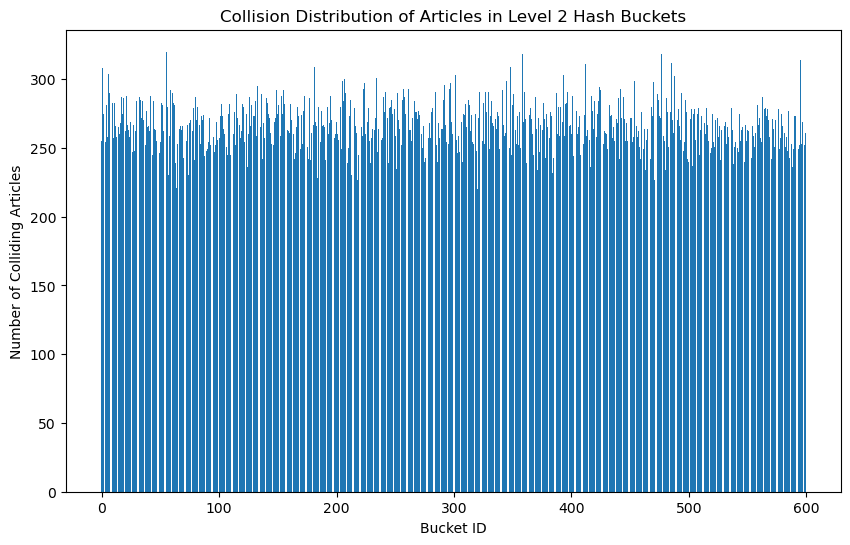

In [136]:
collisions = {}  # Using a dictionary to keep track of collisions
for level_2_hash_table in level_2_hash_tables:
    for bucket_id, articles in level_2_hash_table.items():
        if bucket_id not in collisions:
            collisions[bucket_id] = 0
        collisions[bucket_id] += len(articles)

# Sort the collisions dictionary by keys
sorted_collisions = sorted(collisions.items())

# Extract sorted bucket IDs and bucket lengths
sorted_bucket_ids, bucket_lengths = zip(*sorted_collisions)

# Plot the collision distribution histogram
plt.figure(figsize=(10, 6))
plt.bar(sorted_bucket_ids, bucket_lengths)
plt.xlabel("Bucket ID")
plt.ylabel("Number of Colliding Articles")
plt.title("Collision Distribution of Articles in Level 2 Hash Buckets")
plt.show()


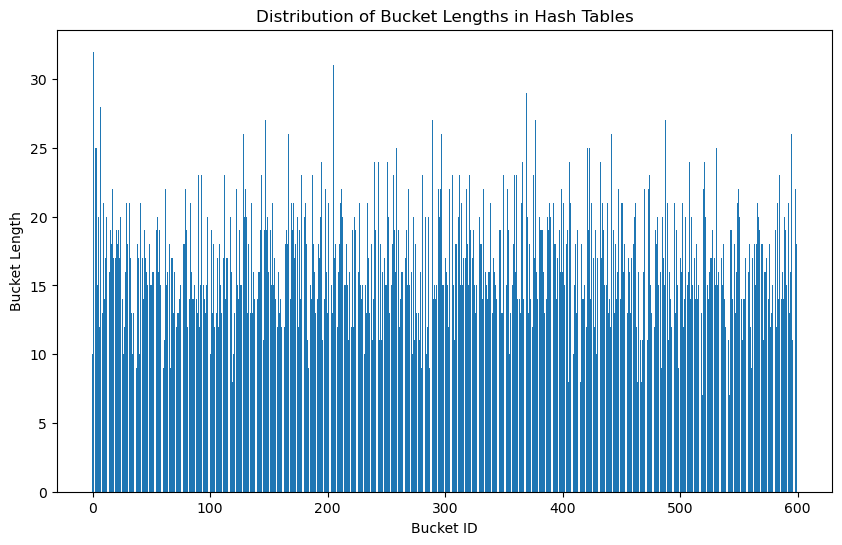

Total number of buckets: 600
Average bucket length: 16.666666666666668


In [146]:
bucket_lengths = {}

for level_2_hash_table in level_2_hash_tables:
    for bucket_id, articles in level_2_hash_table.items():
        bucket_lengths[bucket_id] = len(articles)

# Plot the histogram of bucket lengths with bucket IDs on the X-axis
plt.figure(figsize=(10, 6))
plt.bar(bucket_lengths.keys(), bucket_lengths.values())
plt.xlabel("Bucket ID")
plt.ylabel("Bucket Length")
plt.title("Distribution of Bucket Lengths in Hash Tables")
plt.show()

# Print the total number of buckets and the average bucket length
total_buckets = len(bucket_lengths)
average_bucket_length = sum(bucket_lengths.values()) / total_buckets

print("Total number of buckets:", total_buckets)
print("Average bucket length:", average_bucket_length)

2 Nearest Neighbor Search

(A) Query the LSH tables and return the top-5 articles that have the highest estimated Jaccard similarities
as the answer. Consider articles with an article ID range from 4996 to 5000 as the query set Q = {4996, 4997, 4998, 4999, 5000}.

In [152]:
def jaccard_similarity(signature1, signature2):
    num_matching = np.sum(signature1 == signature2)
    num_total = len(signature1)
    return num_matching / num_total

# Query set Q
query_set = [4996, 4997, 4998, 4999, 5000]

# Initialize a list to store the search results for each query
search_results = []

for query_article_id in query_set:
    query_signature = signature_matrix[query_article_id - 1]  # Subtract 1 to convert to 0-based index
    similar_articles = set()

    for level_2_hash_table in level_2_hash_tables:
        bucket_id = int(hash(tuple(query_signature))) % level_2_m
        if bucket_id in level_2_hash_table:
            similar_articles.update(level_2_hash_table[bucket_id])

    estimated_similarities = [(article_id, jaccard_similarity(query_signature, signature_matrix[article_id - 1]))
                              for article_id in similar_articles if article_id != query_article_id]

    # Sort by estimated Jaccard similarity and get the top-5 articles
    estimated_similarities.sort(key=lambda x: x[1], reverse=True)
    top_5_estimated_similarities = estimated_similarities[:5]

    # Store the search results for this query
    search_results.append(top_5_estimated_similarities)

# Print the search results for each query
for i, query_article_id in enumerate(query_set):
    print(f"Search results for Query Article {query_article_id}:")
    for rank, (article_id, similarity) in enumerate(search_results[i], start=1):
        print(f"{rank}. Article {article_id} with estimated Jaccard similarity: {similarity:.4f}, Genre: {movie_plots[article_id - 1][-1]}")
    print("=" * 40)

Search results for Query Article 4996:
1. Article 1024 with estimated Jaccard similarity: 1.0000, Genre: comedy short
2. Article 2561 with estimated Jaccard similarity: 1.0000, Genre: crime
3. Article 522 with estimated Jaccard similarity: 1.0000, Genre: drama
4. Article 2576 with estimated Jaccard similarity: 1.0000, Genre: romance
5. Article 1554 with estimated Jaccard similarity: 1.0000, Genre: adventure
Search results for Query Article 4997:
1. Article 1024 with estimated Jaccard similarity: 1.0000, Genre: comedy short
2. Article 2561 with estimated Jaccard similarity: 1.0000, Genre: crime
3. Article 522 with estimated Jaccard similarity: 1.0000, Genre: drama
4. Article 2576 with estimated Jaccard similarity: 1.0000, Genre: romance
5. Article 1554 with estimated Jaccard similarity: 1.0000, Genre: adventure
Search results for Query Article 4998:
1. Article 1024 with estimated Jaccard similarity: 1.0000, Genre: comedy short
2. Article 2561 with estimated Jaccard similarity: 1.0000, G

(B) Consider the same query set Q, compute true Jaccard similarity for query q 2 Q and all articles in the
dataset D, i.e., J(di; q) for each article di 2 D. Please report the list of top-5 articles with the highest
true Jaccard similarity in descending order for each article q 2 Q. 

In [153]:
def true_jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0.0

# Query set Q
query_set = [4996, 4997, 4998, 4999, 5000]

# Initialize a list to store the true Jaccard similarities for each query
true_similarities = []

for query_article_id in query_set:
    query_genre = set(movie_plots[query_article_id - 1][1:-1])
    similarities = [(article_id, true_jaccard_similarity(query_genre, set(movie_plots[article_id - 1][1:-1])))
                    for article_id in range(1, len(movie_plots) + 1) if article_id != query_article_id]

    # Sort by true Jaccard similarity and get the top-5 articles
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_5_similarities = similarities[:5]

    # Store the true Jaccard similarities for this query
    true_similarities.append(top_5_similarities)

# Print the true Jaccard similarities for each query
for i, query_article_id in enumerate(query_set):
    print(f"True Jaccard similarities for Query Article {query_article_id}:")
    for rank, (article_id, similarity) in enumerate(true_similarities[i], start=1):
        print(f"{rank}. Article {article_id} with true Jaccard similarity: {similarity:.4f}, Genre: {movie_plots[article_id - 1][-1]}")
    print("=" * 40)

True Jaccard similarities for Query Article 4996:
1. Article 1 with true Jaccard similarity: 1.0000, Genre: western
2. Article 2 with true Jaccard similarity: 1.0000, Genre: short
3. Article 3 with true Jaccard similarity: 1.0000, Genre: biographical
4. Article 4 with true Jaccard similarity: 1.0000, Genre: comedy
5. Article 5 with true Jaccard similarity: 1.0000, Genre: drama
True Jaccard similarities for Query Article 4997:
1. Article 1 with true Jaccard similarity: 1.0000, Genre: western
2. Article 2 with true Jaccard similarity: 1.0000, Genre: short
3. Article 3 with true Jaccard similarity: 1.0000, Genre: biographical
4. Article 4 with true Jaccard similarity: 1.0000, Genre: comedy
5. Article 5 with true Jaccard similarity: 1.0000, Genre: drama
True Jaccard similarities for Query Article 4998:
1. Article 1 with true Jaccard similarity: 1.0000, Genre: western
2. Article 2 with true Jaccard similarity: 1.0000, Genre: short
3. Article 3 with true Jaccard similarity: 1.0000, Genre: bi

3 Estimation Quality and Efficiency

(A) Investigate the impact of the hash size k 2 f2; 4; 8; 16g on the estimated Jaccard similarity estimation.
Consider articles with an article ID range from 4001 to 5000 as the query set Q. For each value of hash
size k, compute the mean absolute error (MAE) for the pairs of articles (di; q), where 1  i  jDj and
q 2 Q. Please plot the MAE of MinHash estimator on different values of k. In particular, MAEs with
different values of k on x-axis (i.e., 2, 4, 8, 16) and MAE values on y-axis. 

In [ ]:
def true_jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0.0

# Query set Q
query_set = range(4001, 5001)  # Article ID range from 4001 to 5000

# Hash size values
hash_sizes = [2, 4, 8, 16]

# Initialize lists to store MAE values for each hash size
mae_values = []

for k in hash_sizes:
    # Generate MinHash functions
    minhash_functions = generate_minhash_functions(k, p)
    
    # Initialize a list to store MAE values for the current hash size
    mae_values_for_k = []
    
    for query_article_id in query_set:
        query_signature = signature_matrix[query_article_id - 1]  # Subtract 1 to convert to 0-based index
        similar_articles = set()

        for level_2_hash_table in level_2_hash_tables:
            bucket_id = int(hash(tuple(query_signature))) % level_2_m
            if bucket_id in level_2_hash_table:
                similar_articles.update(level_2_hash_table[bucket_id])

        true_similarities = [true_jaccard_similarity(set(movie_plots[query_article_id - 1][1:-1]), set(movie_plots[article_id - 1][1:-1]))
                            for article_id in similar_articles if article_id != query_article_id]
        
        estimated_similarities = [jaccard_similarity(signature_matrix[query_article_id - 1], signature_matrix[article_id - 1])
                                  for article_id in similar_articles if article_id != query_article_id]

        # Calculate MAE
        mae = np.mean(np.abs(np.array(true_similarities) - np.array(estimated_similarities)))
        mae_values_for_k.append(mae)
    
    # Store the MAE values for the current hash size
    mae_values.append(np.mean(mae_values_for_k))

# Plot the MAE values for different hash sizes
import matplotlib.pyplot as plt

plt.plot(hash_sizes, mae_values, marker='o')
plt.xlabel('Hash Size (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Impact of Hash Size on MinHash Estimator MAE')
plt.xticks(hash_sizes)
plt.grid(True)
plt.show()